 # Man, Don't Get Angry Tracker
 *Krzysztof Skrobała, Wojciech Bogacz*

 The goal of this project was to detect various events and track gameplay items on a gameplay video in various environments

 We detect the following:

 1. Location (and color) of the home bases
 2. Position and orientation of the board
 3. Location (and color) of the target bases
 4. Location (and color) of pawns
 5. Location of the dice
 6. Number rolled on the dice
 7. Number of pawns inside homes
 8. Number of pawns in targets

#### Full rendered videos can be found [here](https://drive.google.com/drive/folders/1HLXQi8INx-Qkzfh86z-_fYkORSryYyco?usp=sharing)


### Event of rolling a dice (snippet)


In [104]:
%%HTML
<video width="800" controls>
  <source src="report_media/rolling.mp4" type="video/mp4">
</video>

### Event of entering a target base (on medium dataset)

In [98]:
%%HTML
<video width="800" controls>
  <source src="report_media/entering.mp4" type="video/mp4">
</video>

# Dataset
[https://drive.google.com/drive/folders/1HLXQi8INx-Qkzfh86z-_fYkORSryYyco?usp=sharing]()

The dataset is splited into three levels of difficulty

1. **Easy** - No shadows, but  **hands covers** all items on the board <br>
    ![](./report_media/easy.jpeg) <br>
2. Medium - Strong shadows, the camera moves slightly <br>
    ![](./report_media/medium.jpeg) <br>
3. Hard - Same as Medium but from the angle <br>
    ![](./report_media/hard.png) <br>
   
    Unfortunately, the hard dataset turned out to be too challenging for our limited period of time


 # Implementation
 Here, we present processing functions on **the easy dataset**
 
 Example frames from other dataset are in appropriate notebooks

 ### Helpers

In [102]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title=None):
    if title is not None:
        plt.title(title)
    plt.axis("off")
    if len(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap="gray")
    plt.show()

In [4]:
from enum import Enum

class Color(Enum):
    YELLOW = 1
    RED = 2
    GREEN = 3
    BLUE = 4

BGR ={
    Color.YELLOW: (0,255,255),
    Color.RED: (0,0,255),
    Color.GREEN: (0,255,0),
    Color.BLUE: (255,0,0),
}

def get_hsv_scale(lower_hsv, upper_hsv):
    width = upper_hsv[0] - lower_hsv[0]
    height = 100
    hsv_image = np.zeros((height, width, 3), dtype=np.uint8)

    for i in range(width):
        for j in range(height):
            hsv_value = [
                (lower_hsv[0] + i) % 180,  
                ((height - j) * upper_hsv[1] + lower_hsv[1] * j) // height, 
                upper_hsv[2]
            ]
            hsv_image[j, i] = hsv_value

    bgr_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

    return bgr_image


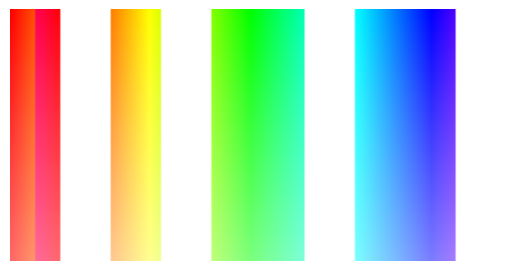

In [8]:
COLOR_RANGES = {
        Color.RED: [
            (np.array([0, 150, 70]), np.array([10, 255, 255])), 
            (np.array([170, 150, 70]), np.array([180, 255, 255]))
        ],
        Color.YELLOW: [
            (np.array([15, 110, 50]), np.array([35, 255, 255]))
        ],
        Color.GREEN: [
            (np.array([45, 130, 50]), np.array([82, 255, 255]))
        ],
        Color.BLUE: [
           (np.array([90, 130, 100]), np.array([130, 255, 255])) 
        ],
    }


scales = []
for ranges in COLOR_RANGES.values():
    for r in ranges:
        scales.append(get_hsv_scale(*r))
    scales.append(255*np.ones((100,20,3), dtype=np.uint8))
imshow(np.concatenate(scales,  1),)


# Function to detect dominant color:


In [7]:
def detect_dominant_color(image_fragment) -> Color:
    hsv = cv2.cvtColor(image_fragment, cv2.COLOR_BGR2HSV)
    
    
    color_counts = {color: 0 for color in COLOR_RANGES.keys()}
    for color, ranges in COLOR_RANGES.items():
        for lower, upper in ranges:
            mask = cv2.inRange(hsv, lower, upper)
            color_counts[color] += cv2.countNonZero(mask)
    dominant_color = max(color_counts, key=color_counts.get)
    
    return dominant_color


# 0. Loading the video

Resolution: 1920 1080


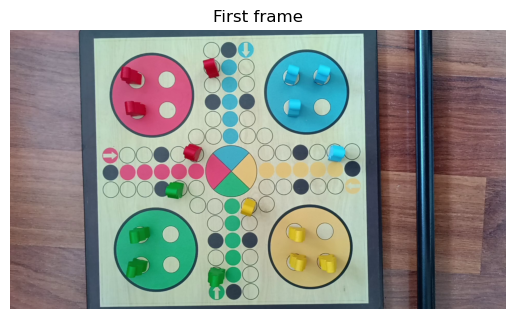

In [10]:

videopath = "./videos/easy/gameplay1.mp4"
cap = cv2.VideoCapture(videopath)
if not cap.isOpened():
    raise Exception("Could not open")


frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

print("Resolution:", frame_width, frame_height)
# 
fps = cap.get(cv2.CAP_PROP_FPS)
fps

_, frame = cap.read()
imshow(frame, "First frame")


 # 1. Detecting homes

 Homes are big clear circles, so we detect them via **Hough circles** transform



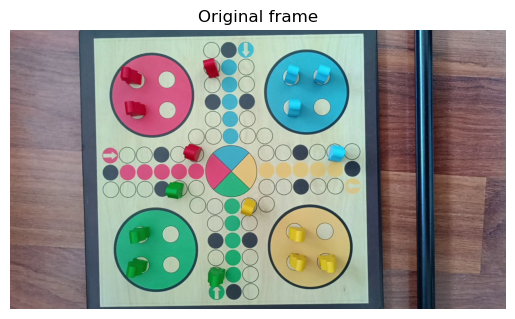

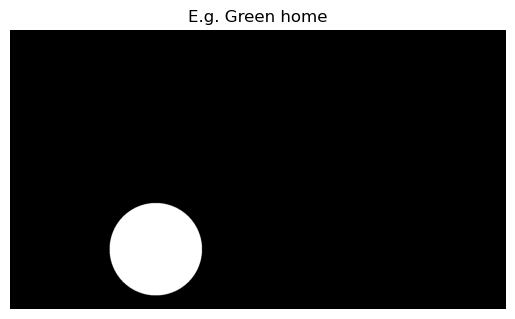

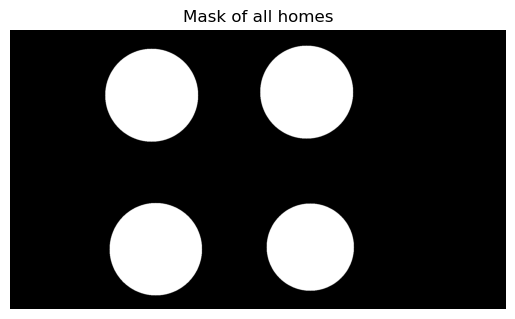

In [13]:
def get_home_masks(frame):
    assert len(frame.shape) == 3, "frame must be BGR"   
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_gray = cv2.medianBlur(frame_gray, 5)
    circles = cv2.HoughCircles(
        frame_gray,
        method = cv2.HOUGH_GRADIENT,
        dp = 1,
        minDist = int(min(frame_height, frame_width) * 0.4),
        param1 = 50,
        param2 = 30,
        minRadius=int(min(frame_height, frame_width) * 0.125),
        maxRadius=int(min(frame_height, frame_width) * 0.25),
    )

    homes = {
                 Color.RED: dict(center = None, radius = None, mask=None),      
                 Color.BLUE: dict(center = None, radius = None, mask=None),
                 Color.GREEN:  dict(center = None, radius = None, mask=None),
                 Color.YELLOW: dict(center = None, radius = None, mask=None),
        }
                 
        
    circles = np.uint16(np.around(circles))
    for ((x,y,r), color) in zip(circles[0,:], homes):
        mask =   np.zeros(frame_gray.shape + (3,), dtype=np.uint8)
        cv2.circle(mask ,(x,y),int(1.1*r),(255,255,255),-1)
        color = detect_dominant_color(frame & mask)
        homes[color]["center"] = (x,y)
        homes[color]["radius"] = r
        homes[color]["mask"] = mask

    return homes

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
homes = get_home_masks(frame)

imshow(frame, "Original frame")
imshow(homes[Color.GREEN]["mask"], title="E.g. Green home")
all_homes_mask = homes[Color.GREEN]["mask"] | homes [Color.RED]["mask"] | homes[Color.YELLOW]["mask"] | homes[Color.BLUE]["mask"]
imshow(all_homes_mask, title="Mask of all homes")



# Board detection 
We tried to obtain board shape by detecting contours and rectangles, but because sometimes part of the board gets off the frame, or a pawn covers part of the board contour we found out that more reliable is calculating board shape from **centers of homes**



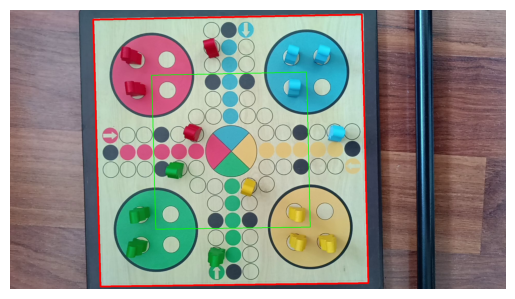

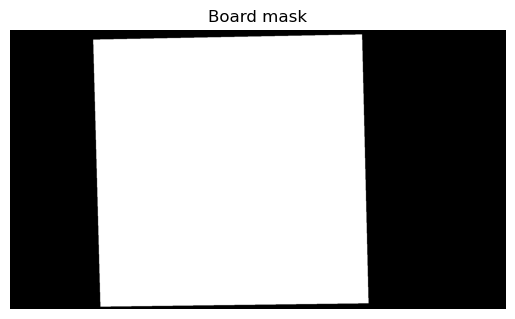

In [14]:
def get_board_mask_from_homes(frame, homes, verbose = False):    
    corners = sorted([home["center"] for home in homes.values()], key = lambda x: x[1])
    top_points = corners[:2]
    bottom_points = corners[2:]
    
    top_left, top_right = sorted(top_points, key=lambda x: x[0])
    bottom_left, bottom_right = sorted(bottom_points, key=lambda x: x[0])

    contour = np.array([top_left, top_right, bottom_right, bottom_left],dtype=np.int32)
    M = cv2.moments(contour)
    if M['m00'] != 0:
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
    else:
        raise ValueError("Something wrong with home centers")

    home_dist_to_board_len_ratio = 26.0 / 15.0
    
    scaled_contour = []
    for point in contour:
        x, y = point
        new_x = cx + home_dist_to_board_len_ratio * (x - cx)
        new_y = cy + home_dist_to_board_len_ratio * (y - cy)
        scaled_contour.append([[int(new_x), int(new_y)]])
        
    scaled_contour = np.array(scaled_contour, dtype=np.int32)
    if verbose:
        output_image = frame.copy()
        cv2.drawContours(output_image, [contour], -1, (0,255,0),2)
        cv2.drawContours(output_image, [scaled_contour], -1, (0,0,255),5)
        imshow(output_image)

    board_mask = np.zeros_like(frame)
    cv2.drawContours(board_mask, [scaled_contour], -1, (255,255,255),-1)
    return board_mask

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
board_mask = get_board_mask_from_homes(frame, homes, verbose=True)
imshow(board_mask, "Board mask")



 # Detecting target bases

 We detect target bases by detecting the central circle, then calculating rectangles which form a cross, and detecting the dominant color in each rectangle



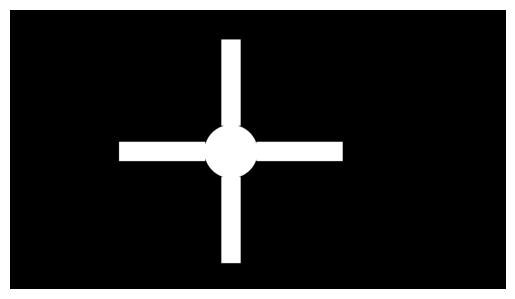

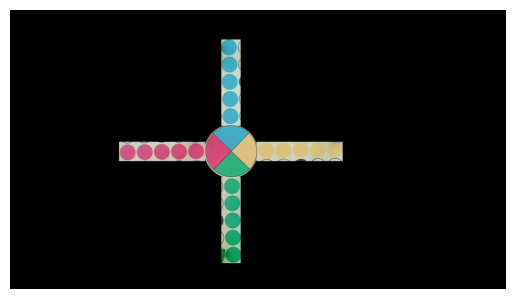

In [17]:
def get_target_bases(frame):
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    circles = cv2.HoughCircles(
            frame_gray,
            method = cv2.HOUGH_GRADIENT,
            dp = 2,
            minDist = int(min(frame_height, frame_width)),
            param1 = 100,
            param2=100,
            minRadius=int(min(frame_height, frame_width) * 0.055),
            maxRadius=int(min(frame_height, frame_width) * 0.1),
        )
    circles = np.uint16(np.around(circles))
    assert len(circles) == 1
    (x,y,r) = circles[0][0]
    targets = dict()
    
    center_circle_mask = np.zeros_like(frame)  
    cv2.circle(center_circle_mask ,(x,y),int(r*1.05),(255,255,255),-1)
    targets["center"] = center_circle_mask
    
    target_base_thickness = int(min(frame_height, frame_width) * 0.07)
    target_base_length = int(min(frame_height, frame_width) * 0.31)
    
    left_target_x = x-r-target_base_length
    left_target_y = y-target_base_thickness//2
    
    up_target_x = x - target_base_thickness//2
    up_target_y = y - r - target_base_length
    
    down_target_x = x - target_base_thickness//2
    down_target_y = y + r
    
    right_target_x = x + r
    right_target_y = y - target_base_thickness//2
    
    
    empty_mask = np.zeros_like(frame)  
    left_target_mask = cv2.rectangle(empty_mask, (left_target_x, left_target_y, target_base_length, target_base_thickness), (255,255,255), -1)
    color = detect_dominant_color(frame & left_target_mask)
    targets[color] = left_target_mask
    
    empty_mask = np.zeros_like(frame)
    up_target_mask = cv2.rectangle(empty_mask, (up_target_x, up_target_y, target_base_thickness, target_base_length ), (255,255,255), -1)
    color = detect_dominant_color(frame & up_target_mask)
    targets[color] = up_target_mask
    
    empty_mask = np.zeros_like(frame)
    down_target_mask = cv2.rectangle(empty_mask, (down_target_x, down_target_y, target_base_thickness, target_base_length), (255,255,255), -1)
    color = detect_dominant_color(frame & down_target_mask)
    targets[color] = down_target_mask
    
    empty_mask = np.zeros_like(frame)   
    right_target_mask = cv2.rectangle(empty_mask, (right_target_x, right_target_y, target_base_length, target_base_thickness), (255,255,255), -1)
    color = detect_dominant_color(frame & right_target_mask)
    targets[color] = right_target_mask

    
    return targets

cap.set(cv2.CAP_PROP_POS_FRAMES,0)
ret, frame = cap.read()
targets = get_target_bases(frame & board_mask)
all_target_bases_mask = targets["center"] | targets[Color.GREEN] | targets[Color.RED]| targets[Color.YELLOW]| targets[Color.BLUE]
imshow(all_target_bases_mask)
imshow(frame & all_target_bases_mask)


 # Masking sidewalk

 Now we can focus on areas of interest like *sidewalk*


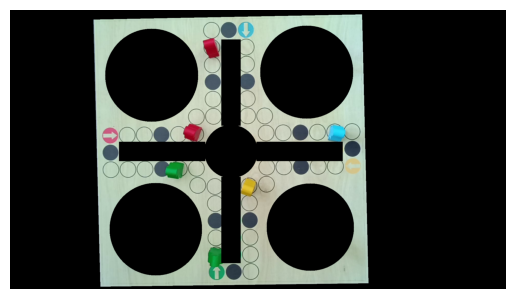

In [18]:
cap.set(cv2.CAP_PROP_POS_FRAMES,0)
ret, frame = cap.read()

homes = get_home_masks(frame)
all_homes_mask = homes[Color.GREEN]["mask"] | homes[Color.RED]["mask"] | homes[Color.YELLOW]["mask"] | homes[Color.BLUE]["mask"]

board_mask = get_board_mask_from_homes(frame, homes)

targets = get_target_bases(frame & board_mask)
all_target_bases_mask = targets["center"] | targets[Color.GREEN] | targets[Color.RED]| targets[Color.YELLOW]| targets[Color.BLUE]

sidewalk = frame & board_mask & ~all_target_bases_mask & ~all_homes_mask

imshow(sidewalk)


# Detecting pawns
Pawns are detected by masking color ranges, then applying morhpological operations - first **aggresive erosion** to delete noise and arrow tiles which are not dense in color, then **dilation** to increase area of marking and to close gaps



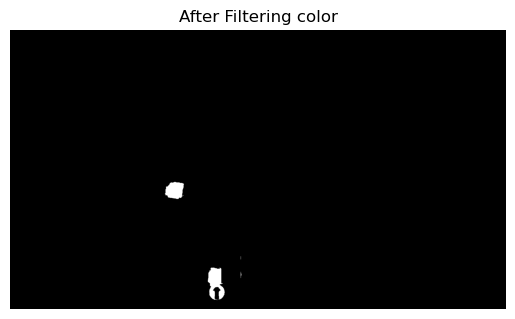

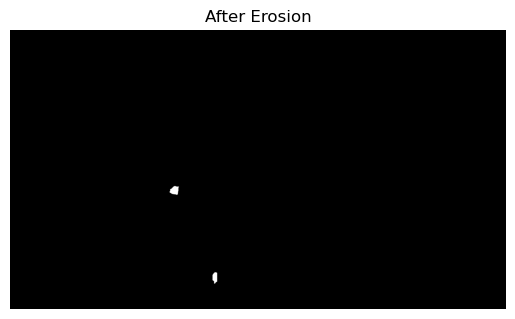

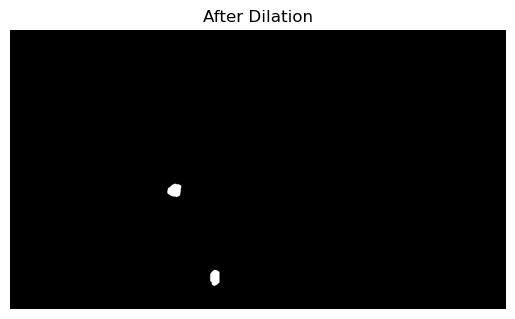

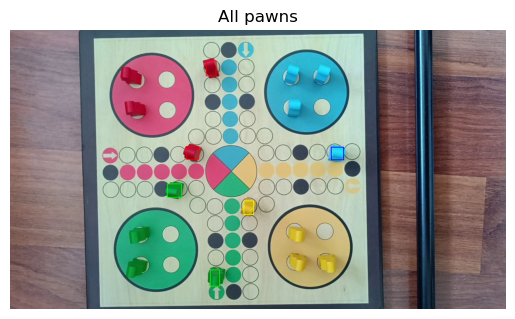

In [20]:
def get_pawn_boxes(sidewalk, color: Color, verbose=False):
    sidewalk_hsv = cv2.cvtColor(sidewalk, cv2.COLOR_BGR2HSV)
        
    ranges = COLOR_RANGES[color]
    mask = np.zeros(sidewalk.shape[:2], dtype=np.uint8)
    for lower, upper in ranges:
        mask |= cv2.inRange(sidewalk_hsv, lower, upper)
    # print(sidewalk_hsv[c], mask[c])
    # imshow(mask)
    if verbose:
        imshow(mask, "After Filtering color")
        
    mask = cv2.morphologyEx(mask, cv2.MORPH_ERODE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5),), iterations=8)
    if verbose:
        imshow(mask, "After Erosion")
        
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7),), iterations=3)
    if verbose:
        imshow(mask, "After Dilation")
        
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    pawn_boxes = []
    min_pawn_area = (min(frame_width, frame_height) * 0.017)**2
    max_pawn_area = (min(frame_width, frame_height) * 0.10)**2
    # imshow(mask)
    
    for contour in contours:
        mini_mask = np.zeros_like(mask)
        area = cv2.contourArea(contour)
        if min_pawn_area < area < max_pawn_area:
            cv2.drawContours(mini_mask, [contour], -1, (255), -1)
            non_zero_pixels = sidewalk_hsv[mini_mask != 0]
            pawn_boxes.append(cv2.boundingRect(contour))
    
                
    return pawn_boxes   

cap.set(cv2.CAP_PROP_POS_FRAMES,0)
ret, frame = cap.read()

board = frame & board_mask
sidewalk = board & ~all_homes_mask & ~all_target_bases_mask

for color in Color:
    pawn_boxes = get_pawn_boxes(sidewalk, color, verbose = True if color == Color.GREEN else False)
    for (x,y,w,h) in pawn_boxes:
        cv2.rectangle(frame, (x, y), (x+w, y+h), BGR[color], 2)

imshow(frame, "All pawns")


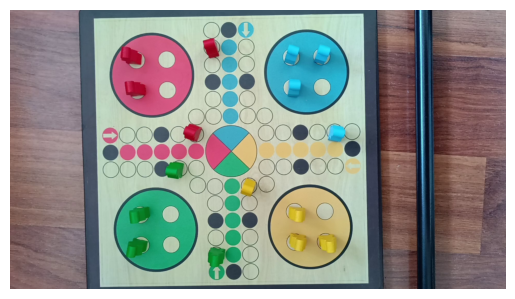

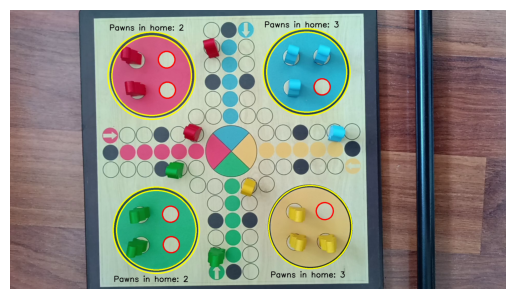

In [22]:
def get_number_of_free_home_places(frame, home, verbose=False):
    home_mask = home["mask"]
    home_radius = home["radius"]
    (cx, cy) = home["center"]

    home_frame =np.zeros_like(frame)
    home_frame[cy-int(1.05*home_radius):cy+int(1.05*home_radius), cx-int(1.05*home_radius):cx+int(1.05*home_radius)] = frame[cy-int(1.05*home_radius):cy+int(1.05*home_radius), cx-int(1.05*home_radius):cx+int(1.05*home_radius)]
    
    home_frame = cv2.cvtColor(home_frame , cv2.COLOR_BGR2GRAY)
    
    home_frame = cv2.GaussianBlur(home_frame, (9,9), 1.5)
    
    # checking if home is visible
    home_circle = cv2.HoughCircles(
        home_frame,
        method = cv2.HOUGH_GRADIENT_ALT,
        dp = 2,
        minDist = int(min(frame_height, frame_width) * 0.4),
        param1 = 350,
        param2 = 0.8,
        minRadius=int(min(frame_height, frame_width) * 0.125),
        maxRadius=int(min(frame_height, frame_width) * 0.25),
    )

    if home_circle is None:
        return None
    if verbose:
        home_circle = np.uint16(np.around(home_circle))
        for (x,y,r) in home_circle[0, :]:
            cv2.circle(frame, (x,y), r, (0,255,255), 3)

    
    circles = cv2.HoughCircles(
                home_frame,
                method = cv2.HOUGH_GRADIENT_ALT,
                dp = 1.5,
                minDist = int(home_radius*0.4),
                param1 = 400,
                param2 = 0.995,
                minRadius=int(home_radius * 0.125),
                maxRadius=int(home_radius * 0.4),
            )
    
    if circles is None:
        return 0
    
    if verbose:
        circles = np.uint16(np.around(circles))
        for (x,y,r) in circles[0, :]:
            cv2.circle(frame, (x,y), r, (0,0,255), 3)

    return circles.shape[1]

cap.set(cv2.CAP_PROP_POS_FRAMES,0)
ret, frame = cap.read()
imshow(frame)
for color in Color:
    empty_places = get_number_of_free_home_places(frame, homes[color], verbose=True)
    if empty_places is None: # home is not visible
        continue
        
    radius = homes[color]["radius"]
    (x,y) = homes[color]["center"]
    if y > frame_height / 2:
        y_text = y+radius+40
    else:
        y_text = y-radius-10
    
    cv2.putText(frame, f"Pawns in home: {4-empty_places}", (x - radius, y_text), cv2.FONT_HERSHEY_SIMPLEX, 1, thickness=2, color=(0,0,0))

imshow(frame)



 # Detecting pawns in target base

 Again, we apply **Hough Circles Transform** to detect covered tiles in masked bases. Unfortunatelly yellow tiles were quite a headache, as they are very similar to the board color, which made it very hard to detect. 

In easy dataset, there is no frame with pawn in the target, but there is such an event (detected) in e.g. medium dataset 



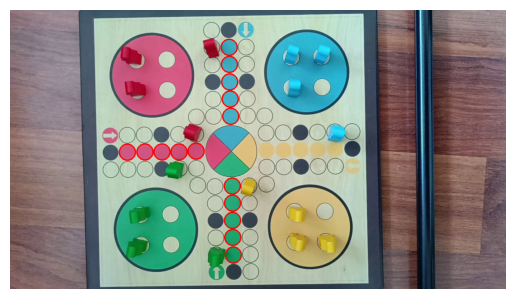

In [25]:
def get_empty_targets(frame, color: Color, verbose=True) -> int:
    frame_gray = cv2.cvtColor(frame & targets[color], cv2.COLOR_BGR2GRAY)
    frame_gray = cv2.GaussianBlur(frame_gray,(7,7),1.5)
    min_radius = int(homes[color]["radius"] * 0.1)
    
    circles = cv2.HoughCircles(
                frame_gray,
                method = cv2.HOUGH_GRADIENT_ALT,
                dp = 1.5,
                minDist = min_radius*2,
                param1 = 300,
                param2 = 0.96,
                minRadius = min_radius,
                maxRadius= 5*min_radius
            )
    
    if circles is None:
        return 0
    if verbose:
        circles = np.uint16(np.around(circles))
        for (x,y,r) in circles[0, :]:
            cv2.circle(frame, (x,y), r, (0,0,255), 3)
    return circles.shape[1]



cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
for color in Color:
    get_empty_targets(frame, color, verbose=True)

imshow(frame)


# Detecting dice
We detect dice by filtering white color, and selecting rectangles after cleaning with morphological operations. Then we are using Hough Circles to find the number

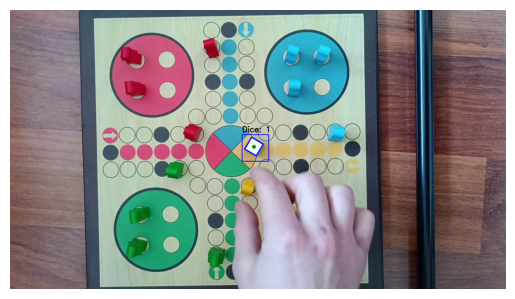

In [105]:
def detect_dice(frame, verbose=False):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    lower_white = np.array([0, 0, 225])
    upper_white = np.array([180, 55, 255])
    
    mask = cv2.inRange(hsv, lower_white, upper_white)
    if verbose:
        imshow(mask, "Masked white")
    
    kernel = np.ones((3, 3), np.uint8)
    mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    if verbose:
        imshow(mask, "Masked white after Closing")
    
    contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cube_list = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if 5000 > area > 1000: 
            perimeter = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)

            if len(approx) == 4 and cv2.isContourConvex(approx):
                cv2.drawContours(frame, [approx], -1, (255, 0, 0), 3)
                cube_list.append(cv2.boundingRect(contour))

    if len(cube_list) == 0:
        return False
    
    
    cube_box = list(cube_list[0])
    cube_box[0]-=10
    cube_box[1]-=10
    cube_box[2]+=30
    cube_box[3]+=30
    top_left = cube_box[:2]
    bottom_right = (top_left[0] + cube_box[2], top_left[1] + cube_box[3])
    
    try:
        ff = frame[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
    
        cube = cv2.cvtColor(ff.copy(), cv2.COLOR_BGR2GRAY)
        trash , cube = cv2.threshold(cube, 180, 255, cv2.THRESH_BINARY)

    except:
        return False

    blurred_t = cv2.GaussianBlur(cube,(3,3),cv2.BORDER_DEFAULT)

    circles = cv2.HoughCircles(
        blurred_t,
        cv2.HOUGH_GRADIENT,
        dp=1.2, 
        minDist=8, 
        param1=60, 
        param2=10,  
        minRadius=7, 
        maxRadius=10 
    )

    if circles is not None:      
        circles = np.uint16(np.around(circles))
        for circle in circles[0, :]:
            x, y, r = circle
            cv2.circle(ff, (x, y), r, (0, 255, 0), 2)
            cv2.circle(ff, (x, y), 2, (0, 0, 255), 3)
        
        cv2.rectangle(frame, top_left, bottom_right, (255, 0, 0), 2)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame, "Dice: "+str(len(circles[0, :])), (top_left[0], top_left[1] - 10), font, 1, (0, 0, 0), 2, cv2.LINE_AA)
    
    return True
        
cap.set(cv2.CAP_PROP_POS_FRAMES, 96)
ret, frame = cap.read()
detect_dice(frame)
imshow(frame)


 # Rednering a video

 Rendering of videos varies among difficulty level, because in ease mode, board doesn't move, so the all masks can be calculated once, but in medium camera moves slowly, so mask are updated every 30 frames etc. Rendering functions are inside notebooks in the repository 
